In [1]:
import numpy as np
import pyomo.environ as pyo
from lineartree import LinearTreeRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from omlt import OmltBlock
from omlt.lineartree import LinearTreeGDPFormulation, LinearTreeModel
import omlt

In [2]:
X = np.array([[-0.68984135],
       [ 0.91672866],
       [-1.05874972],
       [ 0.95275351],
       [ 1.03796615],
       [ 0.45117668],
       [-0.14704376],
       [ 1.66043409],
       [-0.73972191],
       [-0.8176603 ],
       [ 0.96175973],
       [-1.238874  ],
       [-0.97492265],
       [ 1.07121986],
       [-0.95379269],
       [-0.86546252],
       [ 0.8277057 ],
       [ 0.50486757],
       [-1.38435899],
       [ 1.54092856]])

In [3]:
y = np.array([[ 0.04296633],
       [-0.78349216],
       [ 0.27114188],
       [-0.58516476],
       [-0.15997756],
       [-0.37529212],
       [-1.49249696],
       [ 1.56412122],
       [ 0.18697725],
       [ 0.4035928 ],
       [-0.53231771],
       [-0.02669967],
       [ 0.36972983],
       [ 0.09201347],
       [ 0.44041505],
       [ 0.46047019],
       [-1.04855941],
       [-0.586915  ],
       [ 0.15472157],
       [ 1.71225268]])

In [4]:
X.shape

(20, 1)

In [5]:
regr = LinearTreeRegressor(LinearRegression(), 
                            criterion='mse',
                            max_depth=5)

regr.fit(X, y)
y_pred = regr.predict(X)

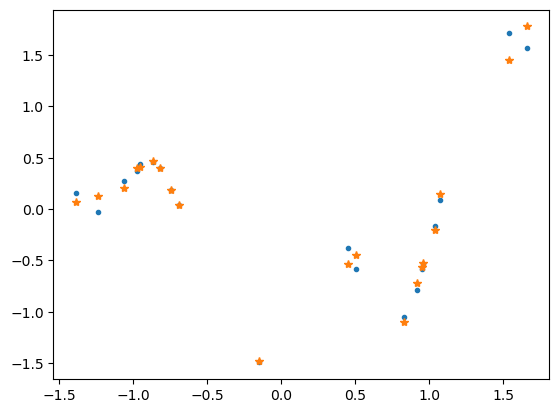

In [6]:
plt.plot(X, y, '.')
plt.plot(X, y_pred, '*')

In [7]:
input_bounds={0:(min(X)[0], max(X)[0])}
input_bounds

{0: (-1.38435899, 1.66043409)}

In [8]:
ltmodel = LinearTreeModel(regr, scaled_input_bounds = input_bounds)

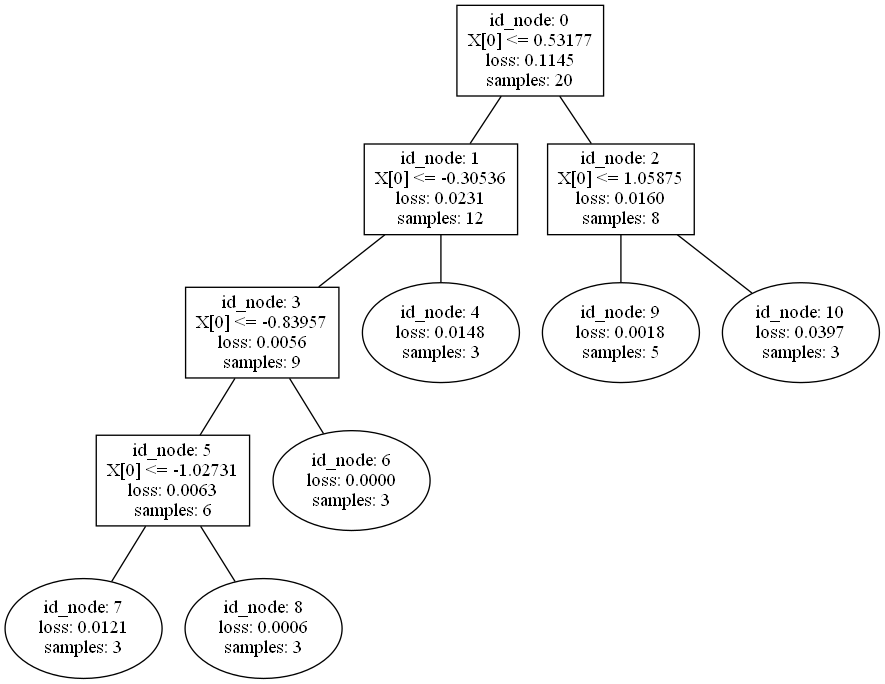

In [9]:
regr.plot_model()

In [10]:
str(type(regr)) == "<class 'lineartree.lineartree.LinearTreeRegressor'>"

True

In [11]:
# ltmodel._n_inputs
# ltmodel._n_outputs

In [12]:
# ltmodel._splits

In [13]:
assert(len(ltmodel._thresholds.keys()) == ltmodel._n_inputs) 

In [14]:
for i in range(len(ltmodel._thresholds.keys())):
    print(ltmodel._thresholds[i])

{5: -1.02731, 3: -0.83957, 1: -0.30536, 0: 0.53177, 2: 1.05875}


In [15]:
# ltmodel._splits
# ltmodel._leaves
# ltmodel._thresholds

In [26]:
ltmodel._leaves

{7: {'loss': 0.01206,
  'samples': 3,
  'models': LinearRegression(),
  'slope': [0.408201],
  'intercept': 0.6340509,
  'parent': 5,
  'bounds': {0: [-1.38435899, -1.02731]}},
 8: {'loss': 0.00056,
  'samples': 3,
  'models': LinearRegression(),
  'slope': [0.65236616],
  'intercept': 1.0311474,
  'parent': 5,
  'bounds': {0: [-1.02731, -0.83957]}},
 6: {'loss': 0.0,
  'samples': 3,
  'models': LinearRegression(),
  'slope': [-2.8176906],
  'intercept': -1.8994815,
  'parent': 3,
  'bounds': {0: [-0.83957, -0.30536]}},
 4: {'loss': 0.01477,
  'samples': 3,
  'models': LinearRegression(),
  'slope': [1.5874636],
  'intercept': -1.246321,
  'parent': 1,
  'bounds': {0: [-0.30536, 0.53177]}},
 9: {'loss': 0.00177,
  'samples': 5,
  'models': LinearRegression(),
  'slope': [4.2484593],
  'intercept': -4.6128316,
  'parent': 2,
  'bounds': {0: [0.53177, 1.05875]}},
 10: {'loss': 0.03967,
  'samples': 3,
  'models': LinearRegression(),
  'slope': [2.7671812],
  'intercept': -2.8182075,
  'p

In [46]:
leaves_key_list = ['loss', 'samples', 'models', 'slope', 'intercept', 'parent', 'bounds']
for j in ltmodel._leaves.keys():
    for key in ltmodel._leaves[j].keys():
        assert(key in leaves_key_list)
        if key == 'slope':
            pass
            # print(len(ltmodel._leaves[j][key]) == ltmodel._n_inputs)
        elif key == 'bounds':
            # print(ltmodel._leaves[j][key])?
            features = ltmodel._leaves[j][key].keys()
            # print(features)
            for k in range(len(features)):
                lb = ltmodel._leaves[j][key][k][0]
                ub = ltmodel._leaves[j][key][k][1]
                print(lb, ub)
                assert(lb <= ub)

-1.38435899 -1.02731
-1.02731 -0.83957
-0.83957 -0.30536
-0.30536 0.53177
0.53177 1.05875
1.05875 1.66043409


In [28]:
# ltmodel._splits.keys()
# key_list = ['col', 'th', 'loss', 'samples', 'parent', 'children', 'models', 'left_leaves', 'right_leaves', 'y_index']
# for i in (ltmodel._splits.keys()):
#     for key in ltmodel._splits[i].keys():
#         assert(key in key_list)

In [17]:
# ltmodel._splits[1]

In [18]:
# ltmodel._leaves[10]

In [19]:
ltmodel._scaled_input_bounds is not None

True

In [20]:
formulation1_lt = LinearTreeGDPFormulation(ltmodel, transformation='bigm')

In [21]:
model1 = pyo.ConcreteModel()
model1.x = pyo.Var(initialize = 0)
model1.y = pyo.Var(initialize = 0)
model1.obj = pyo.Objective(expr=1)
model1.lt = OmltBlock()
model1.lt.build_formulation(formulation1_lt)

model1.x.fix(0.5)

#connect pyomo variables to the neural network
@model1.Constraint()
def connect_inputs(mdl):
    return mdl.x == mdl.lt.inputs[0]

@model1.Constraint()
def connect_outputs(mdl):
    return mdl.y == mdl.lt.outputs[0]

#solve the model and query the solution
status_1_bigm = pyo.SolverFactory('gurobi').solve(model1, tee=True)
pyo.assert_optimal_termination(status_1_bigm)
solution_1_bigm = (pyo.value(model1.x),pyo.value(model1.y))

    solver failure.
Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-17
Read LP format model from file C:\Users\shumengl\AppData\Local\Temp\tmpn9iapzu_.pyomo.lp
Reading time = 0.00 seconds
x13: 30 rows, 12 columns, 72 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 30 rows, 12 columns and 72 nonzeros
Model fingerprint: 0x7c23c980
Variable types: 6 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [4e-01, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [5e-01, 2e+01]
Presolve removed 30 rows and 12 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 8 available proce

In [22]:
solution_1_bigm

(0.5, -0.45258915424345325)

In [23]:
y_pred = regr.predict(np.array(solution_1_bigm[0]).reshape(1,-1))

In [24]:
y_pred[0]- solution_1_bigm[1]

-1.5987211554602254e-14

In [25]:
assert(y_pred[0] - solution_1_bigm[1] <= 1e-3)